# Advent of Code 2018

See [here](http://adventofcode.com/2018/).

## Preparation

Imports and utility functions that might or might not prove useful down the line.

In [1]:
# Python 3.x
import re
import numpy as np
import math
import random
import urllib.request
import reprlib
import operator
import string
import hashlib
import json

from collections import Counter, defaultdict, namedtuple, deque
from functools   import lru_cache, reduce
from itertools   import (permutations, combinations, chain, cycle, tee,
                        product, islice, count, repeat, filterfalse, accumulate)
from heapq       import heappop, heappush
from enum        import Enum

# sometimes a graph helps
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8,8)

def Input(day,strip=True):
    "Open this day's input file."
    
    filename = 'input/input{}.txt'.format(day)
    try:
        with open(filename, 'r') as f:
            text = f.read()
            if strip:
                text = text.strip()
        return text
    except FileNotFoundError:
        url = 'http://adventofcode.com/2018/day/{}/input'.format(day)
        print('input file not found. opening browser...')
        print('please save the file as "input<#day>.txt in your input folder.')
        import webbrowser
        webbrowser.open(url)

cat = ''.join
def first(iterable, default=None): return next(iter(iterable), default)
def nth(iterable, n, default=None): return next(islice(iterable, n, None), default)
def fs(*items): return frozenset(items)

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

def ilen(iterator): return sum(1 for _ in iterator)

def ints(text,typ=int):
    return list(map(typ,re.compile(r'[-+]?\d*[.]?\d+').findall(text)))

def shift(it, n):
    return it[n:] + it[:n]

def rot(mat, N=1, clockwise=True):
    '''rotate 2D matrix'''
    for _ in range(N):
        if clockwise:
            mat = list(zip(*mat[::-1]))
        else:
            mat = list(zip(*mat[::-1]))[::-1]
    return mat

def locate2D(m, val):
    '''locate value in 2D list'''
    for i, line in enumerate(m):
        j=-1
        try:
            j = line.index(val)
        except ValueError:
            continue
        break
    else:
        i = -1
    return (i,j)

def dist_L1(p1,p2=None):
    if p2 == None:
        p2 = repeat(0)
    return sum(abs(p2_i-p1_i) for p1_i, p2_i in zip(p1,p2))

def dist_L2(p1,p2=None):
    if p2 == None:
        p2 = repeat(0)
    return sum((p2_i-p1_i)*(p2_i-p1_i) for p1_i, p2_i in zip(p1,p2))**.5

def neighbors4(point): 
    "The four neighbors (without diagonals)."
    x, y = point
    return ((x+1, y), (x-1, y), (x, y+1), (x, y-1))

def neighbors8(point): 
    "The eight neighbors (with diagonals)."
    x, y = point 
    return ((x+1, y), (x-1, y), (x, y+1), (x, y-1),
            (x+1, y+1), (x-1, y-1), (x+1, y-1), (x-1, y+1))

from numbers import Number 
class Vector(object):
    def __init__(self,*args):
        if len(args) == 1:
            if isinstance(args,Number): self.vec = tuple(0 for _ in range(args))
            else: self.vec = tuple(*args)
        else: self.vec = tuple(args)
    def __mul__(self, other):
        if isinstance(other,Number): return Vector(other * x for x in self.vec)
        elif isinstance(other,Vector): return sum(x*y for x,y in zip(self.vec, other.vec))
        raise NotImplemented
    def __add__(self,other):
        return Vector(x+y for x,y in zip(self.vec, other.vec))
    def __sub__(self,other):
        return Vector(x-y for x,y in zip(self.vec, other.vec))
    def __iter__(self):
        return self.vec.__iter__()
    def __len__(self):
        return len(self.vec)
    def __getitem__(self, key):
        return self.vec[key]
    def __repr__(self):
        return 'Vector(' + str(self.vec)[1:-1] + ')'
    def __eq__(self, other):
        return self.vec == other.vec
    def __hash__(self):
        return hash(self.vec)

#display and debug functions
def h1(s):
    upr, brd, lwr = '▁', '█', '▔'
    return upr*(len(s)+4) + '\n'+brd+' ' + s + ' ' + brd +'\n' + lwr*(len(s)+4)

def h2(s, ch='-'):
    return s + '\n' + ch*len(s) + '\n'

h1 = lambda s: h2(s,'=')  #the other h1 is a bitch, apparently.

def print_result(day, part, text):
    print(h1('Day {} part {}: {}'.format(day, part, text)))

def trace1(f):
    "Print a trace of the input and output of a function on one line."
    rep = reprlib.aRepr
    rep.maxother = 85
    def traced_f(*args):
        arg_strs = ', '.join(map(rep.repr, args))
        result = f(*args)
        print('{}({}) = {}'.format(f.__name__, arg_strs, result))
        return result
    return traced_f

## [Day 1: Chronal Calibration](http://adventofcode.com/2018/day/1)

"We've detected some temporal anomalies," one of Santa's Elves at the <span title="It's about as big on the inside as you expected.">Temporal Anomaly Research and Detection Instrument Station</span> tells you. She sounded pretty worried when she called you down here. "At 500-year intervals into the past, someone has been changing Santa's history!"

"The good news is that the changes won't propagate to our time stream for another 25 days, and we have a device" - she attaches something to your wrist - "that will let you fix the changes with no such propagation delay. It's configured to send you 500 years further into the past every few days; that was the best we could do on such short notice."

"The bad news is that we are detecting roughly *fifty* anomalies throughout time; the device will indicate fixed anomalies with *stars*. The other bad news is that we only have one device and you're the best person for the job! Good lu--" She taps a button on the device and you suddenly feel like you're falling. To save Christmas, you need to get all *fifty stars* by December 25th.

Collect stars by solving puzzles. Two puzzles will be made available on each day in the advent calendar; the second puzzle is unlocked when you complete the first. Each puzzle grants *one star*. Good luck!

After feeling like you've been falling for a few minutes, you look at the device's tiny screen. "Error: Device must be calibrated before first use. Frequency drift detected. Cannot maintain destination lock." Below the message, the device shows a sequence of changes in frequency (your puzzle input). A value like `+6` means the current frequency increases by `6`; a value like `-3` means the current frequency decreases by `3`.

For example, if the device displays frequency changes of `+1, -2, +3, +1`, then starting from a frequency of zero, the following changes would occur:

-   Current frequency ` 0`, change of `+1`; resulting frequency ` 1`.
-   Current frequency ` 1`, change of `-2`; resulting frequency `-1`.
-   Current frequency `-1`, change of `+3`; resulting frequency ` 2`.
-   Current frequency ` 2`, change of `+1`; resulting frequency ` 3`.

In this example, the resulting frequency is `3`.

Here are other example situations:

-   `+1, +1, +1` results in ` 3`
-   `+1, +1, -2` results in ` 0`
-   `-1, -2, -3` results in `-6`

Starting with a frequency of zero, *what is the resulting frequency* after all of the changes in frequency have been applied?

Your puzzle answer was `439`.

### Part Two

You notice that the device repeats the same frequency change list over and over. To calibrate the device, you need to find the first frequency it reaches *twice*.

For example, using the same list of changes above, the device would loop as follows:

-   Current frequency ` 0`, change of `+1`; resulting frequency ` 1`.
-   Current frequency ` 1`, change of `-2`; resulting frequency `-1`.
-   Current frequency `-1`, change of `+3`; resulting frequency ` 2`.
-   Current frequency ` 2`, change of `+1`; resulting frequency ` 3`.
-   (At this point, the device continues from the start of the list.)
-   Current frequency ` 3`, change of `+1`; resulting frequency ` 4`.
-   Current frequency ` 4`, change of `-2`; resulting frequency ` 2`, which has already been seen.

In this example, the first frequency reached twice is `2`. Note that your device might need to repeat its list of frequency changes many times before a duplicate frequency is found, and that duplicates might be found while in the middle of processing the list.

Here are other examples:

-   `+1, -1` first reaches `0` twice.
-   `+3, +3, +4, -2, -4` first reaches `10` twice.
-   `-6, +3, +8, +5, -6` first reaches `5` twice.
-   `+7, +7, -2, -7, -4` first reaches `14` twice.

*What is the first frequency your device reaches twice?*


In [ ]:
data = Input(1)
frequencies = ints(data)

day1_part1 = sum

def day1_part2(frequencies):
    r = 0
    s = set([r])
    for f in cycle(frequencies):
        r += f
        if r in s:
            return r
        s.add(r)

In [ ]:
print_result(1,1,'Frequency is '+str(day1_part1(frequencies)))
print_result(1,2,'first double is ' + str(day1_part2(frequencies)))

## [Day 2: Inventory Management System](http://adventofcode.com/2018/day/2)

You stop falling through time, catch your breath, and check the screen on the device. "Destination reached. Current Year: 1518. Current Location: North Pole Utility Closet 83N10." You made it! Now, to find those anomalies.

Outside the utility closet, you hear footsteps and a voice. "...I'm not sure either. But now that <span title="This is, in fact, roughly when chimneys became common in houses.">so many people have chimneys</span>, maybe he could sneak in that way?" Another voice responds, "Actually, we've been working on a new kind of *suit* that would let him fit through tight spaces like that. But, I heard that a few days ago, they lost the prototype fabric, the design plans, everything! Nobody on the team can even seem to remember important details of the project!"

"Wouldn't they have had enough fabric to fill several boxes in the warehouse? They'd be stored together, so the box IDs should be similar. Too bad it would take forever to search the warehouse for *two similar box IDs*..." They walk too far away to hear any more.

Late at night, you sneak to the warehouse - who knows what kinds of paradoxes you could cause if you were discovered - and use your fancy wrist device to quickly scan every box and produce a list of the likely candidates (your puzzle input).

To make sure you didn't miss any, you scan the likely candidate boxes again, counting the number that have an ID containing *exactly two of any letter* and then separately counting those with *exactly three of any letter*. You can multiply those two counts together to get a rudimentary [checksum](https://en.wikipedia.org/wiki/Checksum) and compare it to what your device predicts.

For example, if you see the following box IDs:

-   `abcdef` contains no letters that appear exactly two or three times.
-   `bababc` contains two `a` and three `b`, so it counts for both.
-   `abbcde` contains two `b`, but no letter appears exactly three times.
-   `abcccd` contains three `c`, but no letter appears exactly two times.
-   `aabcdd` contains two `a` and two `d`, but it only counts once.
-   `abcdee` contains two `e`.
-   `ababab` contains three `a` and three `b`, but it only counts once.

Of these box IDs, four of them contain a letter which appears exactly twice, and three of them contain a letter which appears exactly three times. Multiplying these together produces a checksum of `4 * 3 = 12`.

*What is the checksum* for your list of box IDs?

Your puzzle answer was `7192`.

### Part Two

Confident that your list of box IDs is complete, you're ready to find the boxes full of prototype fabric.

The boxes will have IDs which differ by exactly one character at the same position in both strings. For example, given the following box IDs:

    abcde
    fghij
    klmno
    pqrst
    fguij
    axcye
    wvxyz

The IDs `abcde` and `axcye` are close, but they differ by two characters (the second and fourth). However, the IDs `fghij` and `fguij` differ by exactly one character, the third (`h` and `u`). Those must be the correct boxes.

*What letters are common between the two correct box IDs?* (In the example above, this is found by removing the differing character from either ID, producing `fgij`.)


In [ ]:
data = Input(2).split()

def day2_part1(ids):
    """computing the checksum"""
    data = [Counter(s) for s in ids]
    data = [list(set(v for k,v in s.items() if v == 2 or v == 3)) for s in data if 2 in s.values() or 3 in s.values()]
    data = Counter(sum(data,[]))
    checksum = data[2]*data[3]
    return checksum

test_p1 = ['abcdef', 'bababc', 'abbcde', 'abcccd', 'aabcdd', 'abcdee', 'ababab']
assert day2_part1(test_p1) == 12

def day2_part2(ids):
    """find common letters between matching IDs"""
    for id_1, id_2 in combinations(ids,2):
        common = cat(c_1 for c_1, c_2 in zip(id_1, id_2) if c_1 == c_2)
        if len(common) + 1 == len(id_1):
            return common

test_p2 = ['abcde', 'fghij', 'klmno', 'pqrst', 'fguij', 'axcye', 'wvxyz'] 
assert day2_part2(test_p2) == 'fgij'

In [ ]:
print_result(2,1,'checksum is '+str(day2_part1(data)))
print_result(2,2,'common letters for the matching IDs are "'+str(day2_part2(data))+'"')

## [Day 3: No Matter How You Slice It](http://adventofcode.com/2018/day/3)


The Elves managed to locate the chimney-squeeze prototype fabric for
Santa's suit (thanks to <span title="WAS IT YOU">someone</span> who
helpfully wrote its box IDs on the wall of the warehouse in the middle
of the night). Unfortunately, anomalies are still affecting them -
nobody can even agree on how to *cut* the fabric.

The whole piece of fabric they're working on is a very large square - at
least `1000` inches on each side.

Each Elf has made a *claim* about which area of fabric would be ideal
for Santa's suit. All claims have an ID and consist of a single
rectangle with edges parallel to the edges of the fabric. Each claim's
rectangle is defined as follows:

  - The number of inches between the left edge of the fabric and the
    left edge of the rectangle.
  - The number of inches between the top edge of the fabric and the top
    edge of the rectangle.
  - The width of the rectangle in inches.
  - The height of the rectangle in inches.

A claim like `#123 @ 3,2: 5x4` means that claim ID `123` specifies a
rectangle `3` inches from the left edge, `2` inches from the top edge,
`5` inches wide, and `4` inches tall. Visually, it claims the square
inches of fabric represented by `#` (and ignores the square inches of
fabric represented by `.`) in the diagram below:

    ...........
    ...........
    ...#####...
    ...#####...
    ...#####...
    ...#####...
    ...........
    ...........
    ...........

The problem is that many of the claims *overlap*, causing two or more
claims to cover part of the same areas. For example, consider the
following claims:

    #1 @ 1,3: 4x4
    #2 @ 3,1: 4x4
    #3 @ 5,5: 2x2

Visually, these claim the following areas:

    ........
    ...2222.
    ...2222.
    .11XX22.
    .11XX22.
    .111133.
    .111133.
    ........

The four square inches marked with `X` are claimed by *both `1` and
`2`*. (Claim `3`, while adjacent to the others, does not overlap either
of them.)

If the Elves all proceed with their own plans, none of them will have
enough fabric. *How many square inches of fabric are within two or more
claims?*

### Part 2
Amidst the chaos, you notice that exactly one claim doesn't overlap by even a single square inch of fabric with any other claim. If you can somehow draw attention to it, maybe the Elves will be able to make Santa's suit after all!

For example, in the claims above, only claim 3 is intact after all claims are made.

What is the ID of the only claim that doesn't overlap?


In [ ]:
def d3_parse_claims(data):
    '''created a list of namedtuples claim(id, x, y, w, h) from the input data'''
    claim = namedtuple('claim','id x y w h')
    claims = [ints(d) for d in data.split('\n')]
    claims = [claim(*clm) for clm in claims]
    return claims

def d3_claim_fabric(claims):
    '''create a dict from the claims that has a list of every claim for every square inch'''
    fabric = defaultdict(list)
    for claim in claims:
        for x, y in product(range(claim.x,claim.x+claim.w),
                            range(claim.y,claim.y+claim.h)):
            fabric[(x,y)].append(claim.id)
    return fabric

def day3_part1(claims):
    """find number of square inches with multiple claims"""
    claims = d3_parse_claims(claims)
    fabric = d3_claim_fabric(claims)
    return ilen(k for k,v in fabric.items() if len(v) > 1)

def day3_part2(claims):
    '''find only claim that does not share its area with other claims'''
    claims = d3_parse_claims(claims)
    fabric = d3_claim_fabric(claims)
    num_overlaps = defaultdict(int)
    for sq_claims in fabric.values():
        for sq_claim in sq_claims:
            num_overlaps[sq_claim] = max(num_overlaps[sq_claim], len(sq_claims))
    min_overlap = min(num_overlaps, key=num_overlaps.get)
    assert num_overlaps[min_overlap] == 1
    return min_overlap

In [ ]:
testdata = '''\
#1 @ 1,3: 4x4
#2 @ 3,1: 4x4
#3 @ 5,5: 2x2\
'''
assert day3_part1(testdata) == 4
assert day3_part2(testdata) == 3

In [ ]:
data = Input(3)
print_result(3,1,''+str(day3_part1(data)))
print_result(3,2,''+str(day3_part2(data)))

## [Day 4: Repose Record](http://adventofcode.com/2018/day/4)

You've
<span title="Yes, &#39;sneaked&#39;. &#39;Snuck&#39; didn&#39;t appear in English until the 1800s.">sneaked</span>
into another supply closet - this time, it's across from the prototype
suit manufacturing lab. You need to sneak inside and fix the issues with
the suit, but there's a guard stationed outside the lab, so this is as
close as you can safely get.

As you search the closet for anything that might help, you discover that
you're not the first person to want to sneak in. Covering the walls,
someone has spent an hour starting every midnight for the past few
months secretly observing this guard post\! They've been writing down
the ID of *the one guard on duty that night* - the Elves seem to have
decided that one guard was enough for the overnight shift - as well as
when they fall asleep or wake up while at their post (your puzzle
input).

For example, consider the following records, which have already been
organized into chronological order:

    [1518-11-01 00:00] Guard #10 begins shift
    [1518-11-01 00:05] falls asleep
    [1518-11-01 00:25] wakes up
    [1518-11-01 00:30] falls asleep
    [1518-11-01 00:55] wakes up
    [1518-11-01 23:58] Guard #99 begins shift
    [1518-11-02 00:40] falls asleep
    [1518-11-02 00:50] wakes up
    [1518-11-03 00:05] Guard #10 begins shift
    [1518-11-03 00:24] falls asleep
    [1518-11-03 00:29] wakes up
    [1518-11-04 00:02] Guard #99 begins shift
    [1518-11-04 00:36] falls asleep
    [1518-11-04 00:46] wakes up
    [1518-11-05 00:03] Guard #99 begins shift
    [1518-11-05 00:45] falls asleep
    [1518-11-05 00:55] wakes up

Timestamps are written using `year-month-day hour:minute` format. The
guard falling asleep or waking up is always the one whose shift most
recently started. Because all asleep/awake times are during the midnight
hour (`00:00` - `00:59`), only the minute portion (`00` - `59`) is
relevant for those events.

Visually, these records show that the guards are asleep at these times:

    Date   ID   Minute
                000000000011111111112222222222333333333344444444445555555555
                012345678901234567890123456789012345678901234567890123456789
    11-01  #10  .....####################.....#########################.....
    11-02  #99  ........................................##########..........
    11-03  #10  ........................#####...............................
    11-04  #99  ....................................##########..............
    11-05  #99  .............................................##########.....

The columns are Date, which shows the month-day portion of the relevant
day; ID, which shows the guard on duty that day; and Minute, which shows
the minutes during which the guard was asleep within the midnight hour.
(The Minute column's header shows the minute's ten's digit in the first
row and the one's digit in the second row.) Awake is shown as `.`, and
asleep is shown as `#`.

Note that guards count as asleep on the minute they fall asleep, and
they count as awake on the minute they wake up. For example, because
Guard \#10 wakes up at 00:25 on 1518-11-01, minute 25 is marked as
awake.

If you can figure out the guard most likely to be asleep at a specific
time, you might be able to trick that guard into working tonight so you
can have the best chance of sneaking in. You have two strategies for
choosing the best guard/minute combination.

*Strategy 1:* Find the guard that has the most minutes asleep. What
minute does that guard spend asleep the most?

In the example above, Guard \#10 spent the most minutes asleep, a total
of 50 minutes (20+25+5), while Guard \#99 only slept for a total of 30
minutes (10+10+10). Guard \#*10* was asleep most during minute *24* (on
two days, whereas any other minute the guard was asleep was only seen on
one day).

While this example listed the entries in chronological order, your
entries are in the order you found them. You'll need to organize them
before they can be analyzed.

*What is the ID of the guard you chose multiplied by the minute you
chose?* (In the above example, the answer would be `10 * 24 = 240`.)

### Part Two

*Strategy 2:* Of all guards, which guard is most frequently asleep on
the same minute?

In the example above, Guard \#*99* spent minute *45* asleep more than
any other guard or minute - three times in total. (In all other cases,
any guard spent any minute asleep at most twice.)

*What is the ID of the guard you chose multiplied by the minute you
chose?* (In the above example, the answer would be `99 * 45 = 4455`.)


In [ ]:
def d4_parse_shifts(data):
    data = sorted(data.splitlines())
    guard_buffer = []
    for entry in data:
        if 'Guard' in entry and guard_buffer:
            yield guard_buffer
            guard_buffer = [entry]
        else:
            guard_buffer.append(entry)
    yield guard_buffer

def d4_get_sleep_schedule(shifts):
    sleep_schedule = namedtuple('sleep', 'date guard minutes')
    for shift in shifts:
        line = shift.pop(0)
        guard = int(re.findall(r'Guard #(\d+)', line)[0])
        date = ''
        sleep = list()
        for down, up in zip(*([iter(shift)]*2)):
            Y, M, D, _, m_s = ints(down.replace('-','_'))
            _, _, _, _, m_w = ints(up)
            sleep.extend(range(m_s, m_w))
        yield sleep_schedule((Y,M,D), guard, sleep)

def day4_part1(data):
    """ """
    sleep_schedule = d4_get_sleep_schedule(d4_parse_shifts(data))
    guard_sleep = defaultdict(list)
    for _, guard, minutes in sleep_schedule:
        guard_sleep[guard].extend(minutes)
    sleepy_guard = max(guard_sleep, key=lambda g:len(guard_sleep[g]))
    sleepy_minute = Counter(guard_sleep[sleepy_guard]).most_common(1)[0][0]
    return sleepy_guard * sleepy_minute

def day4_part2(data):
    """ """
    sleep_schedule = d4_get_sleep_schedule(d4_parse_shifts(data))
    guard_sleep = defaultdict(list)
    for _, guard, minutes in sleep_schedule:
        guard_sleep[guard].extend(minutes)
    guard_sleepy_minute = {guard: first(Counter(sleep).most_common(1),default=(0,0))
                           for guard, sleep in guard_sleep.items()}
    sleepy_guard = max(guard_sleepy_minute, key=lambda g:guard_sleepy_minute[g][1])
    sleepy_minute = guard_sleepy_minute[sleepy_guard][0]
    return sleepy_guard * sleepy_minute

In [ ]:
testdata = '''
[1518-11-01 00:00] Guard #10 begins shift
[1518-11-01 00:05] falls asleep
[1518-11-01 00:25] wakes up
[1518-11-01 00:30] falls asleep
[1518-11-01 00:55] wakes up
[1518-11-01 23:58] Guard #99 begins shift
[1518-11-02 00:40] falls asleep
[1518-11-02 00:50] wakes up
[1518-11-03 00:05] Guard #10 begins shift
[1518-11-03 00:24] falls asleep
[1518-11-03 00:29] wakes up
[1518-11-04 00:02] Guard #99 begins shift
[1518-11-04 00:36] falls asleep
[1518-11-04 00:46] wakes up
[1518-11-05 00:03] Guard #99 begins shift
[1518-11-05 00:45] falls asleep
[1518-11-05 00:55] wakes up
'''.strip()
day4_part2(testdata)
assert day4_part1(testdata) == 240
assert day4_part2(testdata) == 4455

In [ ]:
data = Input(4)
print_result(4,1,''+str(day4_part1(data)))
print_result(4,2,''+str(day4_part2(data)))

## [Day 5: Alchemical Reduction](http://adventofcode.com/2018/day/5)

You've managed to sneak in to the prototype suit manufacturing lab. The
Elves are making decent progress, but are still struggling with the
suit's size reduction capabilities.

While the very latest in 1518 alchemical technology might have solved
their problem eventually, you can do better. You scan the chemical
composition of the suit's material and discover that it is formed by
extremely long [polymers](https://en.wikipedia.org/wiki/Polymer) (one of
which is
<span title="I&#39;ve always wanted a polymer!">available</span> as your
puzzle input).

The polymer is formed by smaller *units* which, when triggered, react
with each other such that two adjacent units of the same type and
opposite polarity are destroyed. Units' types are represented by
letters; units' polarity is represented by capitalization. For instance,
`r` and `R` are units with the same type but opposite polarity, whereas
`r` and `s` are entirely different types and do not react.

For example:

  - In `aA`, `a` and `A` react, leaving nothing behind.
  - In `abBA`, `bB` destroys itself, leaving `aA`. As above, this then
    destroys itself, leaving nothing.
  - In `abAB`, no two adjacent units are of the same type, and so
    nothing happens.
  - In `aabAAB`, even though `aa` and `AA` are of the same type, their
    polarities match, and so nothing happens.

Now, consider a larger example, `dabAcCaCBAcCcaDA`:

    dabAcCaCBAcCcaDA  The first 'cC' is removed.
    dabAaCBAcCcaDA    This creates 'Aa', which is removed.
    dabCBAcCcaDA      Either 'cC' or 'Cc' are removed (the result is the same).
    dabCBAcaDA        No further actions can be taken.

After all possible reactions, the resulting polymer contains *10 units*.

*How many units remain after fully reacting the polymer you scanned?*
<span class="quiet">(Note: in this puzzle and others, the input is
large; if you copy/paste your input, make sure you get the whole
thing.)</span>

Your puzzle answer was `9526`.

The first half of this puzzle is complete\! It provides one gold star:
\*

### Part Two

Time to improve the polymer.

One of the unit types is causing problems; it's preventing the polymer
from collapsing as much as it should. Your goal is to figure out which
unit type is causing the most problems, remove all instances of it
(regardless of polarity), fully react the remaining polymer, and measure
its length.

For example, again using the polymer `dabAcCaCBAcCcaDA` from above:

  - Removing all `A`/`a` units produces `dbcCCBcCcD`. Fully reacting
    this polymer produces `dbCBcD`, which has length 6.
  - Removing all `B`/`b` units produces `daAcCaCAcCcaDA`. Fully reacting
    this polymer produces `daCAcaDA`, which has length 8.
  - Removing all `C`/`c` units produces `dabAaBAaDA`. Fully reacting
    this polymer produces `daDA`, which has length 4.
  - Removing all `D`/`d` units produces `abAcCaCBAcCcaA`. Fully reacting
    this polymer produces `abCBAc`, which has length 6.

In this example, removing all `C`/`c` units was best, producing the
answer *4*.

*What is the length of the shortest polymer you can produce* by removing
all units of exactly one type and fully reacting the result?

In [ ]:
def d5_does_react(a, b):
    return a.lower() == b.lower() and a != b


def d5_remove_unit(polymer, unit):
    return cat(u for u in polymer if u.lower() != unit.lower())


def day5_part1(s):
    s_old = ''
    while s_old != s:
        s_old = s
        for i in range(len(s) - 1):
            a, b = s[i], s[i + 1]
            if d5_does_react(a, b):
                s = s[:i] + '##' + s[i + 2:]
        s = s.replace('##', '')
    return len(s)


def day5_part2(data):
    units = set(data.lower())
    results = []
    for unit in units:
        s = d5_remove_unit(data, unit)
        results.append(day5_part1(s))
    return min(results)

In [ ]:
testdata = "dabAcCaCBAcCcaDA"
assert day5_part1(testdata) == len('dabCBAcaDA')
assert day5_part2(testdata) == 4

In [ ]:
data = Input(5)
print_result(5,1,''+str(day5_part1(data)))
print_result(5,2,''+str(day5_part2(data)))

## [Day 6: Chronal Coordinates](http://adventofcode.com/2018/day/6)

The device on your wrist beeps several times, and once again you feel
like you're
falling.

"<span title="Why is the situation always critical? Why can&#39;t the situation just be boring for once?">Situation
critical</span>," the device announces. "Destination indeterminate.
Chronal interference detected. Please specify new target coordinates."

The device then produces a list of coordinates (your puzzle input). Are
they places it thinks are safe or dangerous? It recommends you check
manual page 729. The Elves did not give you a manual.

*If they're dangerous,* maybe you can minimize the danger by finding the
coordinate that gives the largest distance from the other points.

Using only the [Manhattan
distance](https://en.wikipedia.org/wiki/Taxicab_geometry), determine the
*area* around each coordinate by counting the number of
[integer](https://en.wikipedia.org/wiki/Integer) X,Y locations that are
*closest* to that coordinate (and aren't *tied in distance* to any other
coordinate).

Your goal is to find the size of the *largest area* that isn't infinite.
For example, consider the following list of coordinates:

    1, 1
    1, 6
    8, 3
    3, 4
    5, 5
    8, 9

If we name these coordinates `A` through `F`, we can draw them on a
grid, putting `0,0` at the top left:

    ..........
    .A........
    ..........
    ........C.
    ...D......
    .....E....
    .B........
    ..........
    ..........
    ........F.

This view is partial - the actual grid extends infinitely in all
directions. Using the Manhattan distance, each location's closest
coordinate can be determined, shown here in lowercase:

    aaaaa.cccc
    aAaaa.cccc
    aaaddecccc
    aadddeccCc
    ..dDdeeccc
    bb.deEeecc
    bBb.eeee..
    bbb.eeefff
    bbb.eeffff
    bbb.ffffFf

Locations shown as `.` are equally far from two or more coordinates, and
so they don't count as being closest to any.

In this example, the areas of coordinates A, B, C, and F are infinite -
while not shown here, their areas extend forever outside the visible
grid. However, the areas of coordinates D and E are finite: D is closest
to 9 locations, and E is closest to 17 (both including the coordinate's
location itself). Therefore, in this example, the size of the largest
area is *17*.

*What is the size of the largest area* that isn't infinite?

Your puzzle answer was `5429`.

The first half of this puzzle is complete\! It provides one gold star:
\*

### Part Two

On the other hand, *if the coordinates are safe*, maybe the best you can
do is try to find a *region* near as many coordinates as possible.

For example, suppose you want the sum of the [Manhattan
distance](https://en.wikipedia.org/wiki/Taxicab_geometry) to all of the
coordinates to be *less than 32*. For each location, add up the
distances to all of the given coordinates; if the total of those
distances is less than 32, that location is within the desired region.
Using the same coordinates as above, the resulting region looks like
this:

    ..........
    .A........
    ..........
    ...###..C.
    ..#D###...
    ..###E#...
    .B.###....
    ..........
    ..........
    ........F.

In particular, consider the highlighted location `4,3` located at the
top middle of the region. Its calculation is as follows, where `abs()`
is the [absolute value](https://en.wikipedia.org/wiki/Absolute_value)
function:

  - Distance to coordinate A: `abs(4-1) + abs(3-1) =  5`
  - Distance to coordinate B: `abs(4-1) + abs(3-6) =  6`
  - Distance to coordinate C: `abs(4-8) + abs(3-3) =  4`
  - Distance to coordinate D: `abs(4-3) + abs(3-4) =  2`
  - Distance to coordinate E: `abs(4-5) + abs(3-5) =  3`
  - Distance to coordinate F: `abs(4-8) + abs(3-9) = 10`
  - Total distance: `5 + 6 + 4 + 2 + 3 + 10 = 30`

Because the total distance to all coordinates (`30`) is less than 32,
the location is *within* the region.

This region, which also includes coordinates D and E, has a total size
of *16*.

Your actual region will need to be much larger than this example,
though, instead including all locations with a total distance of less
than *10000*.

*What is the size of the region containing all locations which have a
total distance to all given coordinates of less than 10000?*


In [ ]:
from scipy.spatial import ConvexHull

def day6_part1(data):
    coords = ints(data)
    x_coords = coords[0::2]
    y_coords = coords[1::2]
    points = list(zip(x_coords,y_coords))
    np_points = np.array(points)
    hull = ConvexHull(np_points)
    hp = np_points[hull.vertices]
    grid = list(product(range(min(x_coords),max(x_coords)+1),
                        range(min(y_coords),max(y_coords)+1)))
    segm = dict()
    for coord in grid:
        dists = {point: dist_L1(coord, point) for point in points}
        min_dist = min(dists, key=dists.get)
        if ilen(d for d in dists.values() if d == dists[min_dist]) == 1:
            segm[coord] = min_dist
    c = Counter(segm.values())
    for location in hp:
        del(c[tuple(location)])
    return max(c.values())

def day6_part2(data, threshold=10000):
    coords = ints(data)
    x_coords = coords[0::2]
    y_coords = coords[1::2]
    points = list(zip(x_coords,y_coords))
    grid = list(product(range(min(x_coords),max(x_coords)+1),
                        range(min(y_coords),max(y_coords)+1)))
    safe_points = 0
    for coord in grid:
        dists = sum(dist_L1(coord, point) for point in points)
        if dists < threshold:
            safe_points += 1
    return safe_points

In [ ]:
testdata = '''
1, 1
1, 6
8, 3
3, 4
5, 5
8, 9
'''.strip()
assert day6_part1(testdata) == 17
assert day6_part2(testdata, threshold=32) == 16

In [ ]:
data = Input(6)
print_result(6,1,''+str(day6_part1(data)))
print_result(6,2,''+str(day6_part2(data)))

## [Day 7: The Sum of Its Parts](http://adventofcode.com/2018/day/7)

You find yourself standing on a snow-covered coastline; apparently, you
landed a little off course. The region is too hilly to see the North
Pole from here, but you do spot some Elves that seem to be trying to
unpack something that washed ashore. It's quite cold out, so you decide
to risk creating a paradox by asking them for directions.

"Oh, are you the search party?" Somehow, you can understand whatever
Elves from the year 1018 speak; you assume it's [Ancient Nordic
Elvish](/2015/day/6). Could the device on your wrist also be a
translator? "Those clothes don't look very warm; take this." They hand
you a heavy coat.

"We do need to find our way back to the North Pole, but we have higher
priorities at the moment. You see, believe it or not, this box contains
something that will solve all of Santa's transportation problems - at
least, that's what it looks like from the pictures in the instructions."
It doesn't seem like they can read whatever language it's in, but you
can: "Sleigh kit.
<span title="Just some oak and some pine and a handful of Norsemen.">Some
assembly required.</span>"

"'Sleigh'? What a wonderful name\! You must help us assemble this
'sleigh' at once\!" They start excitedly pulling more parts out of the
box.

The instructions specify a series of *steps* and requirements about
which steps must be finished before others can begin (your puzzle
input). Each step is designated by a single letter. For example, suppose
you have the following instructions:

    Step C must be finished before step A can begin.
    Step C must be finished before step F can begin.
    Step A must be finished before step B can begin.
    Step A must be finished before step D can begin.
    Step B must be finished before step E can begin.
    Step D must be finished before step E can begin.
    Step F must be finished before step E can begin.

Visually, these requirements look like this:

``` 
  -->A--->B--
 /    \      \
C      -->D----->E
 \           /
  ---->F-----
```

Your first goal is to determine the order in which the steps should be
completed. If more than one step is ready, choose the step which is
first alphabetically. In this example, the steps would be completed as
follows:

  - Only *`C`* is available, and so it is done first.
  - Next, both `A` and `F` are available. *`A`* is first alphabetically,
    so it is done next.
  - Then, even though `F` was available earlier, steps `B` and `D` are
    now also available, and *`B`* is the first alphabetically of the
    three.
  - After that, only `D` and `F` are available. `E` is not available
    because only some of its prerequisites are complete. Therefore,
    *`D`* is completed next.
  - *`F`* is the only choice, so it is done next.
  - Finally, *`E`* is completed.

So, in this example, the correct order is *`CABDFE`*.

*In what order should the steps in your instructions be completed?*

### Part Two

As you're about to begin construction, four of the Elves offer to help.
"The sun will set soon; it'll go faster if we work together." Now, you
need to account for multiple people working on steps simultaneously. If
multiple steps are available, workers should still begin them in
alphabetical order.

Each step takes 60 seconds plus an amount corresponding to its letter:
A=1, B=2, C=3, and so on. So, step A takes `60+1=61` seconds, while step
Z takes `60+26=86` seconds. No time is required between steps.

To simplify things for the example, however, suppose you only have help
from one Elf (a total of two workers) and that each step takes 60 fewer
seconds (so that step A takes 1 second and step Z takes 26 seconds).
Then, using the same instructions as above, this is how each second
would be spent:

    Second   Worker 1   Worker 2   Done
       0        C          .        
       1        C          .        
       2        C          .        
       3        A          F       C
       4        B          F       CA
       5        B          F       CA
       6        D          F       CAB
       7        D          F       CAB
       8        D          F       CAB
       9        D          .       CABF
      10        E          .       CABFD
      11        E          .       CABFD
      12        E          .       CABFD
      13        E          .       CABFD
      14        E          .       CABFD
      15        .          .       CABFDE

Each row represents one second of time. The Second column identifies how
many seconds have passed as of the beginning of that second. Each worker
column shows the step that worker is currently doing (or `.` if they are
idle). The Done column shows completed steps.

Note that the order of the steps has changed; this is because steps now
take time to finish and multiple workers can begin multiple steps
simultaneously.

In this example, it would take *15* seconds for two workers to complete
these steps.

With *5* workers and the *60+ second* step durations described above,
*how long will it take to complete all of the steps?*


In [ ]:
def d7_parse_data(data):
    data = data.split('\n')
    data = [d.split(' ') for d in data]
    edges = [(d[1], d[7]) for d in data]
    graph = {k: [] for k in sorted(set(chain(*edges)))}
    for first, second in edges:
        graph[second].append(first) # list of conditions
    return graph

def day7_part1(data):
    graph = d7_parse_data(data)
    order = []
    while graph:
        free_node = min(graph, key=lambda n: len(graph.get(n)))
        order.append(free_node)
        for conditions in graph.values():
            if free_node in conditions:
                conditions.remove(free_node)
        graph.pop(free_node)
    return cat(order)

def day7_part2(data, workers=5, basetime=60):
    graph = d7_parse_data(data)
    order = []
    available_workers = list(range(workers))
    rdy_in = dict()
    working_on = {w:None for w in available_workers}
    tasks = list(graph.keys())
    time = 0
    while len(order) < len(tasks):
        free_nodes = [n for n, cond in graph.items() if len(cond) == 0]
        while free_nodes and available_workers:
            free_node = free_nodes.pop(0)
            graph.pop(free_node)
            w = available_workers.pop(0)
            working_on[w] = free_node
            rdy_in[w] = basetime + ord(free_node) - ord('A') + 1
        rdy = min(rdy_in, key=rdy_in.get)
        time += rdy_in[rdy]
        rdy_in = {w: t-rdy_in[rdy] for w,t in rdy_in.items()}
        for item, w in sorted((i, w) for w,i in working_on.items() 
                              if i is not None and rdy_in[w] == 0):
            rdy_in.pop(w)
            available_workers.append(w)
            order.append(item)
            for conditions in graph.values():
                if item in conditions:
                    conditions.remove(item)
            working_on[w] = None
    return time

In [ ]:
testdata = '''
Step C must be finished before step A can begin.
Step C must be finished before step F can begin.
Step A must be finished before step B can begin.
Step A must be finished before step D can begin.
Step B must be finished before step E can begin.
Step D must be finished before step E can begin.
Step F must be finished before step E can begin.
'''.strip()
assert day7_part1(testdata) == 'CABDFE'
assert day7_part2(testdata, workers=2, basetime=0) == 15

In [ ]:
data = Input(7)
print_result(7,1,''+str(day7_part1(data)))
print_result(7,2,''+str(day7_part2(data)))

## [Day 8: Memory Maneuver](http://adventofcode.com/2018/day/8)

The sleigh is much easier to pull than you'd expect for something its weight. Unfortunately, neither you nor the Elves know <span title="It's North. Obviously.">which way</span> the North Pole is from here.

You check your wrist device for anything that might help. It seems to have some kind of navigation system! Activating the navigation system produces more bad news: "Failed to start navigation system. Could not read software license file."

The navigation system's license file consists of a list of numbers (your puzzle input). The numbers define a data structure which, when processed, produces some kind of [tree](https://en.wikipedia.org/wiki/Tree_(data_structure)) that can be used to calculate the license number.

The *tree* is made up of *nodes*; a single, outermost node forms the tree's *root*, and it contains all other nodes in the tree (or contains nodes that contain nodes, and so on).

Specifically, a node consists of:

-   A *header*, which is always exactly two numbers:
    -   The quantity of child nodes.
    -   The quantity of metadata entries.
-   Zero or more *child nodes* (as specified in the header).
-   One or more *metadata entries* (as specified in the header).

Each child node is itself a node that has its own header, child nodes, and metadata. For example:

    2 3 0 3 10 11 12 1 1 0 1 99 2 1 1 2
    A----------------------------------
        B----------- C-----------
                         D-----

In this example, each node of the tree is also marked with an underline starting with a letter for easier identification. In it, there are four nodes:

-   `A`, which has `2` child nodes (`B`, `C`) and `3` metadata entries (`1`, `1`, `2`).
-   `B`, which has `0` child nodes and `3` metadata entries (`10`, `11`, `12`).
-   `C`, which has `1` child node (`D`) and `1` metadata entry (`2`).
-   `D`, which has `0` child nodes and `1` metadata entry (`99`).

The first check done on the license file is to simply add up all of the metadata entries. In this example, that sum is `1+1+2+10+11+12+2+99=138`.

*What is the sum of all metadata entries?*


### Part Two

The second check is slightly more complicated: you need to find the value of the root node (`A` in the example above).

The *value of a node* depends on whether it has child nodes.

If a node has *no child nodes*, its value is the sum of its metadata entries. So, the value of node `B` is `10+11+12=33`, and the value of node `D` is `99`.

However, if a node *does have child nodes*, the metadata entries become indexes which refer to those child nodes. A metadata entry of `1` refers to the first child node, `2` to the second, `3` to the third, and so on. The value of this node is the sum of the values of the child nodes referenced by the metadata entries. If a referenced child node does not exist, that reference is skipped. A child node can be referenced multiple time and counts each time it is referenced. A metadata entry of `0` does not refer to any child node.

For example, again using the above nodes:

-   Node `C` has one metadata entry, `2`. Because node `C` has only one child node, `2` references a child node which does not exist, and so the value of node `C` is `0`.
-   Node `A` has three metadata entries: `1`, `1`, and `2`. The `1` references node `A`'s first child node, `B`, and the `2` references node `A`'s second child node, `C`. Because node B has a value of `33` and node `C` has a value of `0`, the value of node `A` is `33+33+0=66`.

So, in this example, the value of the root node is `66`.

*What is the value of the root node?*


In [ ]:
class Node:
    def __init__(self, index, children, meta):
        self.index = index
        self.children = children
        self.meta = meta
        
    def __repr__(self):
        return 'Node(index="{}", children={}, meta={})'.format(self.index, self.children, self.meta)

def d8_parse_input(data):
    data = ints(data)
    node, rest = d8_build_tree(data)
    return node.children[0]

def d8_build_tree(data, num_child=1, num_meta=0, index=-1):
    children = []
    idx = index
    while num_child > 0:
        index += 1
        nc, nm, *data = data
        node, data = d8_build_tree(data, num_child=nc, num_meta=nm, index=index)
        children.append(node)
        num_child -= 1
    meta, rest = data[:num_meta], data[num_meta:]    
    return Node(idx, children, meta), rest


def day8_part1(data):
    def walk_tree_meta(node):
        metadata = node.meta
        for child in node.children:
            metadata.extend(walk_tree_meta(child))
        return metadata
    tree = d8_parse_input(data)
    metadata = walk_tree_meta(tree)
    return sum(metadata)
    

def day8_part2(data):
    def get_node_value(node):
        if len(node.children) == 0:
            return sum(node.meta)
        value = 0
        for meta in node.meta:
            if meta <= len(node.children):
                value += get_node_value(node.children[meta-1])
        return value
    tree = d8_parse_input(data)
    return get_node_value(tree)

In [ ]:
testdata = '2 3 0 3 10 11 12 1 1 0 1 99 2 1 1 2'
assert day8_part1(testdata) == 138
assert day8_part2(testdata) == 66

In [ ]:
data = Input(8)
print_result(8,1,''+str(day8_part1(data)))
print_result(8,2,''+str(day8_part2(data)))

## [Day 9: Marble Mania](http://adventofcode.com/2018/day/9)

You talk to the Elves while you wait for your navigation system to <span title="Do you have any idea how long it takes to load navigation data for all of time and space?!">initialize</span>. To pass the time, they introduce you to their favorite [marble](https://en.wikipedia.org/wiki/Marble_(toy)) game.

The Elves play this game by taking turns arranging the marbles in a *circle* according to very particular rules. The marbles are numbered starting with `0` and increasing by `1` until every marble has a number.

First, the marble numbered `0` is placed in the circle. At this point, while it contains only a single marble, it is still a circle: the marble is both clockwise from itself and counter-clockwise from itself. This marble is designated the *current marble*.

Then, each Elf takes a turn placing the *lowest-numbered remaining marble* into the circle between the marbles that are `1` and `2` marbles *clockwise* of the current marble. (When the circle is large enough, this means that there is one marble between the marble that was just placed and the current marble.) The marble that was just placed then becomes the *current marble*.

However, if the marble that is about to be placed has a number which is a multiple of `23`, *something entirely different happens*. First, the current player keeps the marble they would have placed, adding it to their *score*. In addition, the marble `7` marbles *counter-clockwise* from the current marble is *removed* from the circle and *also* added to the current player's score. The marble located immediately *clockwise* of the marble that was removed becomes the new *current marble*.

For example, suppose there are 9 players. After the marble with value `0` is placed in the middle, each player (shown in square brackets) takes a turn. The result of each of those turns would produce circles of marbles like this, where clockwise is to the right and the resulting current marble is in parentheses:

    [-] (0)
    [1]  0 (1)
    [2]  0 (2) 1 
    [3]  0  2  1 (3)
    [4]  0 (4) 2  1  3 
    [5]  0  4  2 (5) 1  3 
    [6]  0  4  2  5  1 (6) 3 
    [7]  0  4  2  5  1  6  3 (7)
    [8]  0 (8) 4  2  5  1  6  3  7 
    [9]  0  8  4 (9) 2  5  1  6  3  7 
    [1]  0  8  4  9  2(10) 5  1  6  3  7 
    [2]  0  8  4  9  2 10  5(11) 1  6  3  7 
    [3]  0  8  4  9  2 10  5 11  1(12) 6  3  7 
    [4]  0  8  4  9  2 10  5 11  1 12  6(13) 3  7 
    [5]  0  8  4  9  2 10  5 11  1 12  6 13  3(14) 7 
    [6]  0  8  4  9  2 10  5 11  1 12  6 13  3 14  7(15)
    [7]  0(16) 8  4  9  2 10  5 11  1 12  6 13  3 14  7 15 
    [8]  0 16  8(17) 4  9  2 10  5 11  1 12  6 13  3 14  7 15 
    [9]  0 16  8 17  4(18) 9  2 10  5 11  1 12  6 13  3 14  7 15 
    [1]  0 16  8 17  4 18  9(19) 2 10  5 11  1 12  6 13  3 14  7 15 
    [2]  0 16  8 17  4 18  9 19  2(20)10  5 11  1 12  6 13  3 14  7 15 
    [3]  0 16  8 17  4 18  9 19  2 20 10(21) 5 11  1 12  6 13  3 14  7 15 
    [4]  0 16  8 17  4 18  9 19  2 20 10 21  5(22)11  1 12  6 13  3 14  7 15 
    [5]  0 16  8 17  4 18(19) 2 20 10 21  5 22 11  1 12  6 13  3 14  7 15 
    [6]  0 16  8 17  4 18 19  2(24)20 10 21  5 22 11  1 12  6 13  3 14  7 15 
    [7]  0 16  8 17  4 18 19  2 24 20(25)10 21  5 22 11  1 12  6 13  3 14  7 15

The goal is to be the *player with the highest score* after the last marble is used up. Assuming the example above ends after the marble numbered `25`, the winning score is `23+9=32` (because player 5 kept marble `23` and removed marble `9`, while no other player got any points in this very short example game).

Here are a few more examples:

-   `10` players; last marble is worth `1618` points: high score is *`8317`*
-   `13` players; last marble is worth `7999` points: high score is *`146373`*
-   `17` players; last marble is worth `1104` points: high score is *`2764`*
-   `21` players; last marble is worth `6111` points: high score is *`54718`*
-   `30` players; last marble is worth `5807` points: high score is *`37305`*

*What is the winning Elf's score?*

### Part Two

Amused by the speed of your answer, the Elves are curious:

*What would the new winning Elf's score be if the number of the last marble were 100 times larger?*


In [6]:
def day9_part1(data):
    max_players, last_marble = ints(data)
    scores = defaultdict(int)
    circle = deque([0])

    for marble in range(1, last_marble + 1):
        if marble % 23 == 0:
            circle.rotate(7)
            scores[marble % max_players] += marble + circle.pop()
            circle.rotate(-1)
        else:
            circle.rotate(-1)
            circle.append(marble)
    return max(list(scores.values()))

def day9_part2(data):
    players, marbles = ints(data)
    return day9_part1('{}, {}'.format(players, 100*marbles))

In [8]:
assert day9_part1(' 9 players; last marble is worth   25 points') == 32
assert day9_part1('10 players; last marble is worth 1618 points') == 8317
assert day9_part1('13 players; last marble is worth 7999 points') == 146373
assert day9_part1('17 players; last marble is worth 1104 points') == 2764
assert day9_part1('21 players; last marble is worth 6111 points') == 54718
assert day9_part1('30 players; last marble is worth 5807 points') == 37305

In [9]:
data = Input(9)
print_result(9,1,''+str(day9_part1(data)))
print_result(9,2,''+str(day9_part2(data)))

Day 9 part 1: 439341

Day 9 part 2: 3566801385



## [Day 10: The Stars Align](http://adventofcode.com/2018/day/10)

It's no use; your navigation system simply isn't capable of providing
<span title="At the iceberg, use any lane to turn left. Then, swim for eight thousand miles.">walking
directions</span> in the arctic circle, and certainly not in 1018.

The Elves suggest an alternative. In times like these, North Pole rescue
operations will arrange points of light in the sky to guide missing
Elves back to base. Unfortunately, the message is easy to miss: the
points move slowly enough that it takes hours to align them, but have so
much momentum that they only stay aligned for a second. If you blink at
the wrong time, it might be hours before another message appears.

You can see these points of light floating in the distance, and record
their position in the sky and their velocity, the relative change in
position per second (your puzzle input). The coordinates are all given
from your perspective; given enough time, those positions and velocities
will move the points into a cohesive message\!

Rather than wait, you decide to fast-forward the process and calculate
what the points will eventually spell.

For example, suppose you note the following points:

    position=< 9,  1> velocity=< 0,  2>
    position=< 7,  0> velocity=<-1,  0>
    position=< 3, -2> velocity=<-1,  1>
    position=< 6, 10> velocity=<-2, -1>
    position=< 2, -4> velocity=< 2,  2>
    position=<-6, 10> velocity=< 2, -2>
    position=< 1,  8> velocity=< 1, -1>
    position=< 1,  7> velocity=< 1,  0>
    position=<-3, 11> velocity=< 1, -2>
    position=< 7,  6> velocity=<-1, -1>
    position=<-2,  3> velocity=< 1,  0>
    position=<-4,  3> velocity=< 2,  0>
    position=<10, -3> velocity=<-1,  1>
    position=< 5, 11> velocity=< 1, -2>
    position=< 4,  7> velocity=< 0, -1>
    position=< 8, -2> velocity=< 0,  1>
    position=<15,  0> velocity=<-2,  0>
    position=< 1,  6> velocity=< 1,  0>
    position=< 8,  9> velocity=< 0, -1>
    position=< 3,  3> velocity=<-1,  1>
    position=< 0,  5> velocity=< 0, -1>
    position=<-2,  2> velocity=< 2,  0>
    position=< 5, -2> velocity=< 1,  2>
    position=< 1,  4> velocity=< 2,  1>
    position=<-2,  7> velocity=< 2, -2>
    position=< 3,  6> velocity=<-1, -1>
    position=< 5,  0> velocity=< 1,  0>
    position=<-6,  0> velocity=< 2,  0>
    position=< 5,  9> velocity=< 1, -2>
    position=<14,  7> velocity=<-2,  0>
    position=<-3,  6> velocity=< 2, -1>

Each line represents one point. Positions are given as `<X, Y>` pairs: X
represents how far left (negative) or right (positive) the point
appears, while Y represents how far up (negative) or down (positive) the
point appears.

At `0` seconds, each point has the position given. Each second, each
point's velocity is added to its position. So, a point with velocity
`<1, -2>` is moving to the right, but is moving upward twice as quickly.
If this point's initial position were `<3, 9>`, after `3` seconds, its
position would become `<6, 3>`.

Over time, the points listed above would move like this:

    Initially:
    ........#.............
    ................#.....
    .........#.#..#.......
    ......................
    #..........#.#.......#
    ...............#......
    ....#.................
    ..#.#....#............
    .......#..............
    ......#...............
    ...#...#.#...#........
    ....#..#..#.........#.
    .......#..............
    ...........#..#.......
    #...........#.........
    ...#.......#..........
    
    After 1 second:
    ......................
    ......................
    ..........#....#......
    ........#.....#.......
    ..#.........#......#..
    ......................
    ......#...............
    ....##.........#......
    ......#.#.............
    .....##.##..#.........
    ........#.#...........
    ........#...#.....#...
    ..#...........#.......
    ....#.....#.#.........
    ......................
    ......................
    
    After 2 seconds:
    ......................
    ......................
    ......................
    ..............#.......
    ....#..#...####..#....
    ......................
    ........#....#........
    ......#.#.............
    .......#...#..........
    .......#..#..#.#......
    ....#....#.#..........
    .....#...#...##.#.....
    ........#.............
    ......................
    ......................
    ......................
    
    After 3 seconds:
    ......................
    ......................
    ......................
    ......................
    ......#...#..###......
    ......#...#...#.......
    ......#...#...#.......
    ......#####...#.......
    ......#...#...#.......
    ......#...#...#.......
    ......#...#...#.......
    ......#...#..###......
    ......................
    ......................
    ......................
    ......................
    
    After 4 seconds:
    ......................
    ......................
    ......................
    ............#.........
    ........##...#.#......
    ......#.....#..#......
    .....#..##.##.#.......
    .......##.#....#......
    ...........#....#.....
    ..............#.......
    ....#......#...#......
    .....#.....##.........
    ...............#......
    ...............#......
    ......................
    ......................

After 3 seconds, the message appeared briefly: `HI`. Of course, your
message will be much longer and will take many more seconds to appear.

*What message will eventually appear in the sky?*


### Part Two

Good thing you didn't have to wait, because that would have taken a long
time - much longer than the `3` seconds in the example above.

Impressed by your sub-hour communication capabilities, the Elves are
curious: *exactly how many seconds would they have needed to wait for
that message to appear?*


In [69]:
from scipy.optimize import fmin

def d10_parse_input(data):
    data = ints(data)
    x = np.array(data[0::4])
    y = np.array(data[1::4])
    vx = np.array(data[2::4])
    vy = np.array(data[3::4])
    return x, y, vx, vy

def d10_find_time(y, vy):
    dist = lambda i: np.ptp(y+i*vy) # its probably gonna be the minimum.
    i = fmin(dist, 0, disp=False)
    return np.int32(i[0])

def day10_part1(data):
    x, y, vx, vy = d10_parse_input(data)
    i = d10_find_time(y, vy)
    x += i * vx
    y += i * vy
    x -= np.amin(x)
    y -= np.amin(y)
    img = np.zeros((np.amax(y)+1, np.amax(x)+1))
    img[y,x] = 1
    _ = plt.imshow(img, cmap='Greys',  interpolation='nearest')
    _ =plt.axis('off')
    return 'see graph'

def day10_part2(data):
    _, y, _, vy = d10_parse_input(data)
    return d10_find_time(y, vy)

   

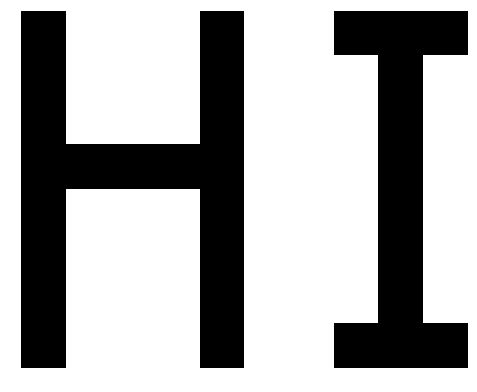

In [70]:
testdata = '''
position=< 9,  1> velocity=< 0,  2>
position=< 7,  0> velocity=<-1,  0>
position=< 3, -2> velocity=<-1,  1>
position=< 6, 10> velocity=<-2, -1>
position=< 2, -4> velocity=< 2,  2>
position=<-6, 10> velocity=< 2, -2>
position=< 1,  8> velocity=< 1, -1>
position=< 1,  7> velocity=< 1,  0>
position=<-3, 11> velocity=< 1, -2>
position=< 7,  6> velocity=<-1, -1>
position=<-2,  3> velocity=< 1,  0>
position=<-4,  3> velocity=< 2,  0>
position=<10, -3> velocity=<-1,  1>
position=< 5, 11> velocity=< 1, -2>
position=< 4,  7> velocity=< 0, -1>
position=< 8, -2> velocity=< 0,  1>
position=<15,  0> velocity=<-2,  0>
position=< 1,  6> velocity=< 1,  0>
position=< 8,  9> velocity=< 0, -1>
position=< 3,  3> velocity=<-1,  1>
position=< 0,  5> velocity=< 0, -1>
position=<-2,  2> velocity=< 2,  0>
position=< 5, -2> velocity=< 1,  2>
position=< 1,  4> velocity=< 2,  1>
position=<-2,  7> velocity=< 2, -2>
position=< 3,  6> velocity=<-1, -1>
position=< 5,  0> velocity=< 1,  0>
position=<-6,  0> velocity=< 2,  0>
position=< 5,  9> velocity=< 1, -2>
position=<14,  7> velocity=<-2,  0>
position=<-3,  6> velocity=< 2, -1>'''.strip()
day10_part1(testdata)
assert day10_part2(testdata) == 3

Day 10 part 1: see graph

Day 10 part 2: 10634



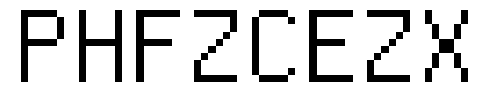

In [71]:
data = Input(10)
print_result(10,1,''+str(day10_part1(data)))
print_result(10,2,''+str(day10_part2(data)))

## [Day 11: Chronal Charge](http://adventofcode.com/2018/day/11)

You watch the Elves and their sleigh fade into the distance as they head
toward the North Pole.

Actually, you're the one fading. The
<span title="wheeeeeeeeeeeeeeeeee">falling sensation</span> returns.

The low fuel warning light is illuminated on your wrist-mounted device.
Tapping it once causes it to project a hologram of the situation: a
*300x300* grid of fuel cells and their current power levels, some
negative. You're not sure what negative power means in the context of
time travel, but it can't be good.

Each fuel cell has a coordinate ranging *from 1 to 300* in both the X
(horizontal) and Y (vertical) direction. In `X,Y` notation, the top-left
cell is `1,1`, and the top-right cell is `300,1`.

The interface lets you select *any 3x3 square* of fuel cells. To
increase your chances of getting to your destination, you decide to
choose the 3x3 square with the *largest total power*.

The power level in a given fuel cell can be found through the following
process:

  - Find the fuel cell's *rack ID*, which is its *X coordinate plus 10*.
  - Begin with a power level of the *rack ID* times the *Y coordinate*.
  - Increase the power level by the value of the *grid serial number*
    (your puzzle input).
  - Set the power level to itself multiplied by the *rack ID*.
  - Keep only the *hundreds digit* of the power level (so `12345`
    becomes `3`; numbers with no hundreds digit become `0`).
  - *Subtract 5* from the power level.

For example, to find the power level of the fuel cell at `3,5` in a grid
with serial number `8`:

  - The rack ID is `3 + 10 = 13`.
  - The power level starts at `13 * 5 = 65`.
  - Adding the serial number produces `65 + 8 = 73`.
  - Multiplying by the rack ID produces `73 * 13 = 949`.
  - The hundreds digit of `949` is `9`.
  - Subtracting 5 produces `9 - 5 = 4`.

So, the power level of this fuel cell is `4`.

Here are some more example power levels:

  - Fuel cell at  `122,79`, grid serial number `57`: power level `-5`.
  - Fuel cell at `217,196`, grid serial number `39`: power level  `0`.
  - Fuel cell at `101,153`, grid serial number `71`: power level  `4`.

Your goal is to find the 3x3 square which has the largest total power.
The square must be entirely within the 300x300 grid. Identify this
square using the `X,Y` coordinate of its *top-left fuel cell*. For
example:

For grid serial number `18`, the largest total 3x3 square has a top-left
corner of `33,45` (with a total power of `29`); these fuel cells appear
in the middle of this 5x5 region:

    -2  -4   4   4   4
    -4   4   4   4  -5
     4   3   3   4  -4
     1   1   2   4  -3
    -1   0   2  -5  -2

For grid serial number `42`, the largest 3x3 square's top-left is
`21,61` (with a total power of `30`); they are in the middle of this
region:

    -3   4   2   2   2
    -4   4   3   3   4
    -5   3   3   4  -4
     4   3   3   4  -3
     3   3   3  -5  -1

*What is the `X,Y` coordinate of the top-left fuel cell of the 3x3
square with the largest total power?*

### Part 2
You discover a dial on the side of the device; it seems to let you
select a square of *any size*, not just 3x3. Sizes from 1x1 to 300x300
are supported.

Realizing this, you now must find the *square of any size with the
largest total power*. Identify this square by including its size as a
third parameter after the top-left coordinate: a 9x9 square with a
top-left corner of `3,5` is identified as `3,5,9`.

For example:

  - For grid serial number `18`, the largest total square (with a total
    power of `113`) is 16x16 and has a top-left corner of `90,269`, so
    its identifier is `90,269,16`.
  - For grid serial number `42`, the largest total square (with a total
    power of `119`) is 12x12 and has a top-left corner of `232,251`, so
    its identifier is `232,251,12`.

*What is the `X,Y,size` identifier of the square with the largest total
power?*


In [52]:
def d11_gen_summed_area_table(serial, grid):
    nx, ny = grid
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    power = ((((x+10)*(serial+y*(x+10)))//100)%10)-5
    POWER = power.cumsum(axis=0).cumsum(axis=1) #summed area table
    return POWER

result = namedtuple('result', 'val x y size')

def day11_part1(serial, grid=(300, 300), window=(3,3)):
    POWER = d11_gen_summed_area_table(int(serial), grid)
    ww, wh = window
    region_power = POWER[:-ww,:-wh] + POWER[ww:,wh:] - POWER[ww:,:-wh] - POWER[:-ww,wh:]
    max_val = np.amax(region_power)
    max_y, max_x = np.unravel_index(np.argmax(region_power, axis=None), region_power.shape)
    return f'P({max_x+1}, {max_y+1})={max_val}'

def day11_part2(serial, grid=(300, 300)):
    POWER = d11_gen_summed_area_table(int(serial), grid)
    max_power_table = []
    for i in range(1, 300):
        ww = wh = i
        region_power = POWER[:-ww,:-wh] + POWER[ww:,wh:] - POWER[ww:,:-wh] - POWER[:-ww,wh:]
        max_val = np.amax(region_power)
        max_y, max_x = np.unravel_index(np.argmax(region_power, axis=None), region_power.shape)
        max_power_table.append(result(max_val, max_x+1, max_y+1, i))
    return max(max_power_table)

In [56]:
assert day11_part1(18) == 'P(33, 45)=29'
assert day11_part1(42) == 'P(21, 61)=30'
assert day11_part2(18) == result(val=113, x=90, y=269, size=16)
assert day11_part2(42) == result(val=119, x=232, y=251, size=12)

In [58]:
data = Input(11)
print_result(11,1,str(day11_part1(data)))
print_result(11,2,str(day11_part2(data)))

Day 11 part 1: P(20, 37)=31

Day 11 part 2: result(val=103, x=90, y=169, size=15)



## [Day 12](http://adventofcode.com/2018/day/12)

In [ ]:
data = Input(12)

def day12_part1(data):
    """ """
    pass

def day12_part2(data):
    """ """
    pass

In [ ]:
testdata = '''

'''.strip()
assert day12_part1(testdata) == None
assert day12_part2(testdata) == None

In [ ]:
data = Input(12)
print_result(12,1,''+str(day12_part1(data)))
print_result(12,2,''+str(day12_part2(data)))

## [Day 13](http://adventofcode.com/2018/day/13)

In [ ]:
data = Input(13)

def day13_part1(data):
    """ """
    pass

def day13_part2(data):
    """ """
    pass

In [ ]:
testdata = '''

'''.strip()
assert day13_part1(testdata) == None
assert day13_part2(testdata) == None

In [ ]:
data = Input(13)
print_result(13,1,''+str(day13_part1(data)))
print_result(13,2,''+str(day13_part2(data)))

## [Day 14](http://adventofcode.com/2018/day/14)

In [ ]:
data = Input(14)

def day14_part1(data):
    """ """
    pass

def day14_part2(data):
    """ """
    pass

In [ ]:
testdata = '''

'''.strip()
assert day14_part1(testdata) == None
assert day14_part2(testdata) == None

In [ ]:
data = Input(14)
print_result(14,1,''+str(day14_part1(data)))
print_result(14,2,''+str(day14_part2(data)))

## [Day 15](http://adventofcode.com/2018/day/15)

In [ ]:
data = Input(15)

def day15_part1(data):
    """ """
    pass

def day15_part2(data):
    """ """
    pass

In [ ]:
testdata = '''

'''.strip()
assert day15_part1(testdata) == None
assert day15_part2(testdata) == None

In [ ]:
data = Input(15)
print_result(15,1,''+str(day15_part1(data)))
print_result(15,2,''+str(day15_part2(data)))

## [Day 16](http://adventofcode.com/2018/day/16)

In [ ]:
data = Input(16)

def day16_part1(data):
    """ """
    pass

def day16_part2(data):
    """ """
    pass

In [ ]:
testdata = '''

'''.strip()
assert day16_part1(testdata) == None
assert day16_part2(testdata) == None

In [ ]:
data = Input(16)
print_result(16,1,''+str(day16_part1(data)))
print_result(16,2,''+str(day16_part2(data)))